In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns

In [2]:
class PerformanceAnalyzer:
    def __init__(self, directory, name):
        """
        Initializes the PerformanceAnalyzer with a list of file names.

        :param files: List of file paths to process.
        """
        self.name = name
        self.original_times = []
        self.avx_times = []
        self.scores = []
        self.text_lengths = []
        self.pattern_lengths = []
        self.texts = []
        self.patterns = []
        self.improvements = []
        self.speedups = []

        self.files = ["150.txt", "300.txt", "500.txt", "750.txt", "1000.txt"]
        self.files = [os.path.join(directory, file) for file in self.files]

    def extract_data(self):
        """Reads all files and extracts relevant data using regex."""
        for file_name in self.files:
            with open(file_name, "r") as file:
                data = file.read()

            # Extract execution times, scores, text lengths, and pattern lengths
            self.original_times += list(map(float, re.findall(r"Execution Time \(Original\)\s*:\s*([\d.]+)", data)))
            self.avx_times += list(map(float, re.findall(r"Execution Time \(AVX\)\s*:\s*([\d.]+)", data)))
            self.scores += list(map(int, re.findall(r"Score:\s*([-]?\d+)", data)))
            self.text_lengths += list(map(int, re.findall(r"Text\s*\[Sequence \d+\] \(Length\s*(\d+)\)", data)))
            self.pattern_lengths += list(map(int, re.findall(r"Pattern\s*\[Sequence \d+\] \(Length\s*(\d+)\)", data)))

            self.texts += re.findall(r"Text\s*\[Sequence \d+\] \(Length\s*\d+\):\s*(.+)", data)
            self.patterns += re.findall(r"Pattern\s*\[Sequence \d+\] \(Length\s*\d+\):\s*(.+)", data)

    def compute_metrics(self):
        """Computes speedup and improvement percentage."""
        if not self.original_times or not self.avx_times:
            raise ValueError("No data available. Run extract_data() first.")

        self.speedups = [o / a if a != 0 else float("inf") for o, a in zip(self.original_times, self.avx_times)]
        self.improvements = [(o - a) / o * 100 if o != 0 else 0 for o, a in zip(self.original_times, self.avx_times)]

    def calculate_standard_deviation(self):
        """Calculates standard deviation for original and AVX times."""
        self.original_std_dev = np.std(self.original_times)
        self.avx_std_dev = np.std(self.avx_times)

    def print_metrics(self):
        # Ensure lengths match before plotting
        print(f"Original Times Length: {len(self.original_times)}")
        print(f"AVX Times Length: {len(self.avx_times)}")
        print(f"Scores Length: {len(self.scores)}")
        print(f"Text Lengths Length: {len(self.text_lengths)}")
        print(f"Pattern Lengths Length: {len(self.pattern_lengths)}")
        print(f"Improvements Length: {len(self.improvements)}")

    def plot_performance_improvement(self):
        plt.figure(figsize=(10, 15))
        plt.subplot(3, 1, 1)
        plt.bar(self.pattern_lengths, self.improvements, color='skyblue')
        plt.xlabel("Pattern Length")
        plt.ylabel("Performance Improvement (%)")
        plt.title("Performance Improvement of AVX over Original Execution (Pattern Length)")
        plt.xticks(self.pattern_lengths)
        plt.grid(axis='y', linestyle="--", alpha=0.7)

        plt.subplot(3, 1, 2)
        plt.scatter(self.text_lengths, self.improvements, color='lightcoral', alpha=0.7)
        plt.xlabel("Text Length")
        plt.ylabel("Performance Improvement (%)")
        plt.title("Performance Improvement of AVX over Original Execution (Text Length)")
        plt.grid(axis='y', linestyle="--", alpha=0.7)

        plt.subplot(3, 1, 3)
        plt.scatter(self.scores, self.improvements, color='lightgreen', alpha=0.7)
        plt.xlabel("Score")
        plt.ylabel("Performance Improvement (%)")
        plt.title("Performance Improvement of AVX over Original Execution (Score)")
        plt.grid(axis='y', linestyle="--", alpha=0.7)

        plt.tight_layout()
        plt.show()

    def plot_execution_time_comparison(self):
        fig, axes = plt.subplots(3, 1, figsize=(10, 15))
        fig.suptitle("Execution Time Comparison", fontsize=16)

        axes[0].scatter(self.scores, self.original_times, color='blue', alpha=0.7, label="Original")
        axes[0].scatter(self.scores, self.avx_times, color='red', alpha=0.7, label="AVX")
        coeffs_original = np.polyfit(self.scores, self.original_times, 1)
        poly_original = np.poly1d(coeffs_original)
        axes[0].plot(self.scores, poly_original(self.scores), color='blue', linestyle='--', label="Original Fit Line")
        coeffs_avx = np.polyfit(self.scores, self.avx_times, 1)
        poly_avx = np.poly1d(coeffs_avx)
        axes[0].plot(self.scores, poly_avx(self.scores), color='red', linestyle='--', label="AVX Fit Line")
        axes[0].set_xlabel("Score")
        axes[0].set_ylabel("Execution Time [ms]")
        axes[0].set_title("Execution Time vs. Score")
        axes[0].grid(True, linestyle="--", alpha=0.7)
        axes[0].legend()

        axes[1].scatter(self.text_lengths, self.original_times, color='blue', alpha=0.7, label="Original")
        axes[1].scatter(self.text_lengths, self.avx_times, color='red', alpha=0.7, label="AVX")
        axes[1].set_xlabel("Text Length")
        axes[1].set_ylabel("Execution Time [ms]")
        axes[1].set_title("Execution Time vs. Text Length")
        axes[1].grid(True, linestyle="--", alpha=0.7)
        axes[1].legend()

        pattern_set = sorted(set(self.pattern_lengths))
        axes[2].boxplot([np.array(self.original_times)[np.array(self.pattern_lengths) == p] for p in pattern_set], 
                        positions=[p - 30 for p in pattern_set], widths=50, patch_artist=True,
                        boxprops=dict(facecolor="blue", color="blue"),
                        whiskerprops=dict(color="blue"),
                        capprops=dict(color="blue"),
                        flierprops=dict(markerfacecolor="blue", marker="o"))

        axes[2].boxplot([np.array(self.avx_times)[np.array(self.pattern_lengths) == p] for p in pattern_set], 
                        positions=[p + 30 for p in pattern_set], widths=50, patch_artist=True,
                        boxprops=dict(facecolor="red", color="red"),
                        whiskerprops=dict(color="red"),
                        capprops=dict(color="red"),
                        flierprops=dict(markerfacecolor="red", marker="o"))

        axes[2].set_xlabel("Pattern Length")
        axes[2].set_ylabel("Execution Time [ms]")
        axes[2].set_title("Execution Time vs. Pattern Length")
        axes[2].set_xticks(pattern_set)
        axes[2].set_xticklabels(pattern_set, rotation=45)
        axes[2].grid(True, linestyle="--", alpha=0.7)
        axes[2].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_execution_time_vs_score(self):
        # Create a figure and axis
        plt.figure(figsize=(10, 7))
    
        # Scatter plots for original times and AVX times
        plt.scatter(self.text_lengths, self.original_times, color='blue', alpha=0.7, label="Original")
        plt.scatter(self.text_lengths, self.avx_times, color='red', alpha=0.7, label="AVX")
    
        # Linear fit for original times
        coeffs_original = np.polyfit(self.text_lengths, self.original_times, 1)
        poly_original = np.poly1d(coeffs_original)
        plt.plot(self.text_lengths, poly_original(self.text_lengths), color='blue', linestyle='--', label="Original Fit Line")
    
        # Linear fit for AVX times
        coeffs_avx = np.polyfit(self.text_lengths, self.avx_times, 1)
        poly_avx = np.poly1d(coeffs_avx)
        plt.plot(self.text_lengths, poly_avx(self.text_lengths), color='red', linestyle='--', label="AVX Fit Line")
    
        # Labels, title, grid, and legend
        plt.xlabel("Text Length")
        plt.ylabel("Execution Time [ms]")
        plt.title("Execution Time vs. Score")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
    
        # Show the plot
        plt.show()

    def get_max_score_details(self):
        """Finds the maximum score and returns the corresponding text length and pattern length."""
        """Finds the maximum score and returns the corresponding text and pattern."""
        if not self.scores:
            raise ValueError("No scores available. Run extract_data() first.")
    
        max_score_index = self.scores.index(max(self.scores))  # Get index of max score
    
        return {
            "max_score": self.scores[max_score_index],
            "text": self.texts[max_score_index],
            "pattern": self.patterns[max_score_index]
        }
        
    def plot_all(self):
        self.plot_performance_improvement()
        self.plot_execution_time_comparison()

In [3]:
directory_to_name = {
    "complete": "results/all",
    "B": "results/B",
    "BE": "results/B+E",
    "BN": "results/B+N",
    "E": "results/E",
    "EN": "results/E+N",
    "N": "results/N",
    "O": "results/O",
    "OB": "results/O+B",
    "OE": "results/O+E",
    "ON": "results/O+N",
    "ENB": "results/E+N+B",
    "ENO": "results/E+N+O",
    "ONB": "results/O+N+B"
}

In [4]:
performance_analyzers = {name: PerformanceAnalyzer(directory, name) 
                         for name, directory in directory_to_name.items()}

In [5]:
for name, analyzer in performance_analyzers.items():
    print(f"Processing {name}...")
    analyzer.extract_data()
    analyzer.compute_metrics()
    max_score_details = analyzer.get_max_score_details()

Processing complete...
Processing B...
Processing BE...
Processing BN...
Processing E...
Processing EN...
Processing N...
Processing O...
Processing OB...
Processing OE...
Processing ON...
Processing ENB...
Processing ENO...
Processing ONB...


Processing E with AVX slope: -0.0124, Original slope: -0.0117, Difference: -0.0006


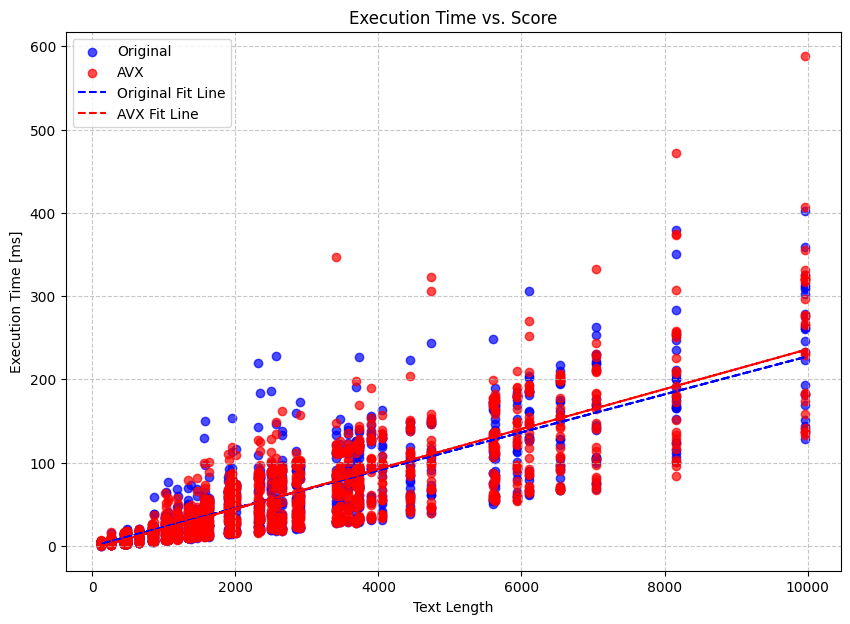

Processing OE with AVX slope: -0.0121, Original slope: -0.0118, Difference: -0.0003


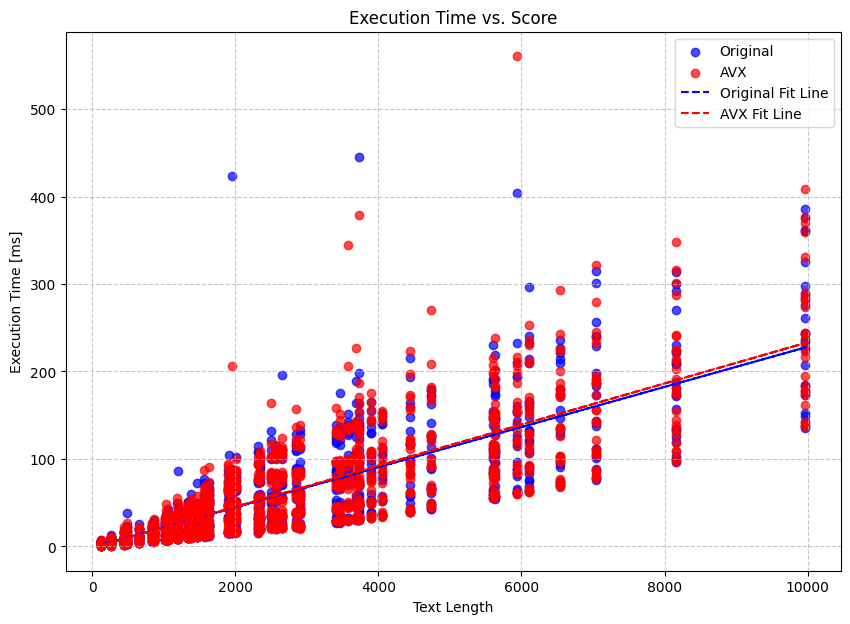

Processing B with AVX slope: -0.0104, Original slope: -0.0102, Difference: -0.0001


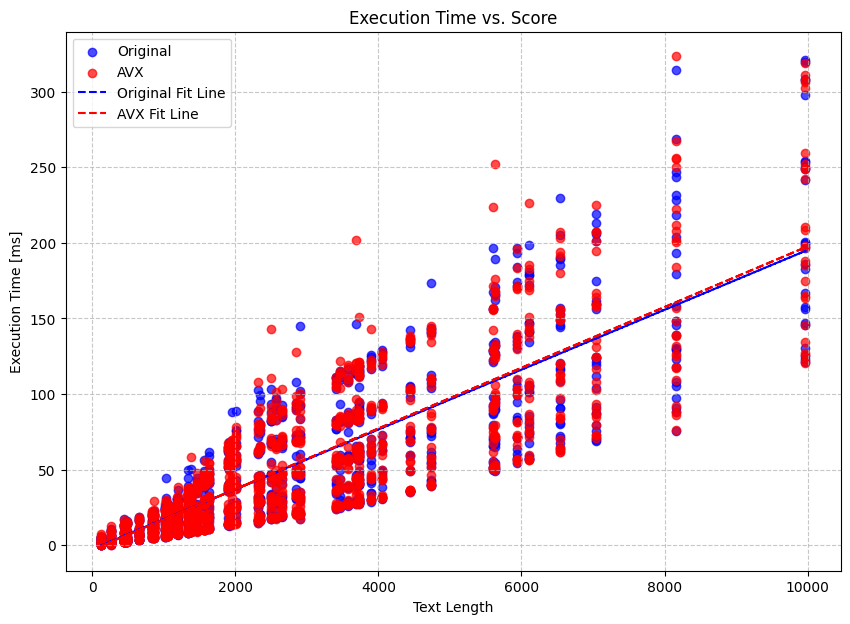

Processing BE with AVX slope: -0.0097, Original slope: -0.0096, Difference: -0.0001


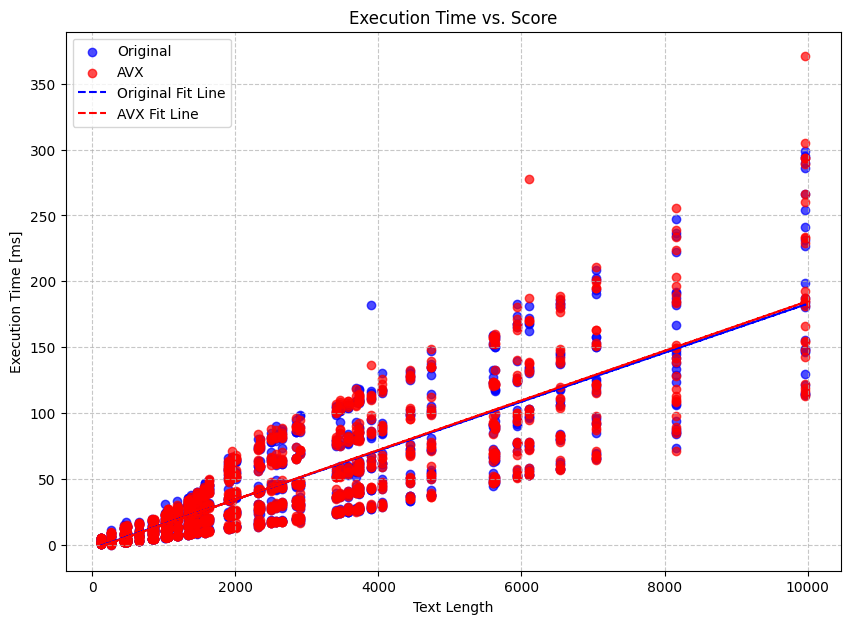

Processing O with AVX slope: -0.0134, Original slope: -0.0133, Difference: -0.0001


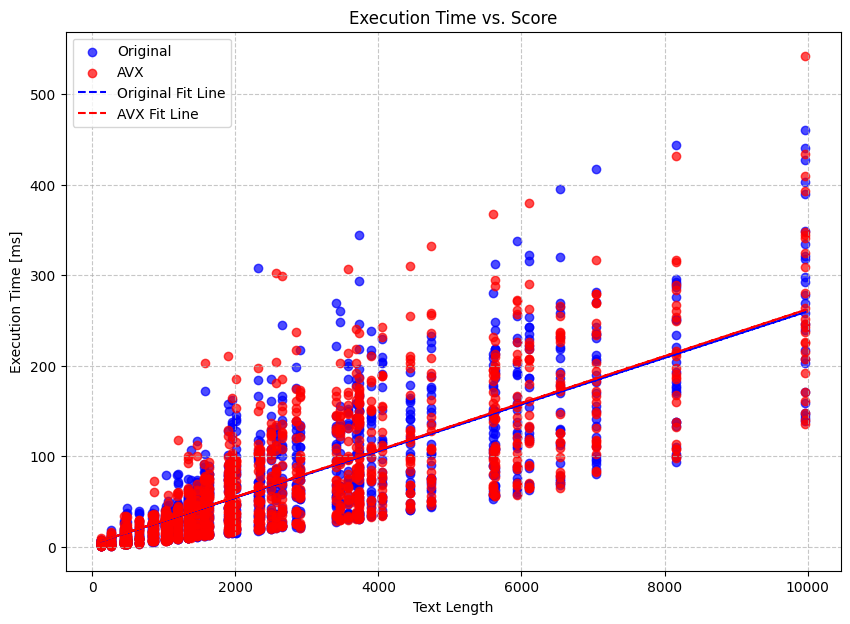

Processing OB with AVX slope: -0.0098, Original slope: -0.0098, Difference: 0.0000


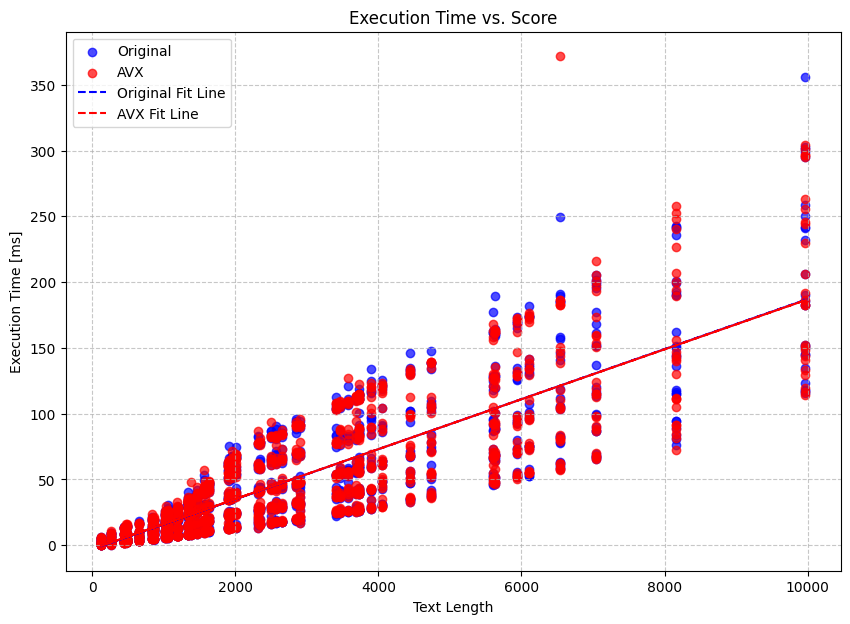

Processing ENO with AVX slope: -0.0100, Original slope: -0.0101, Difference: 0.0001


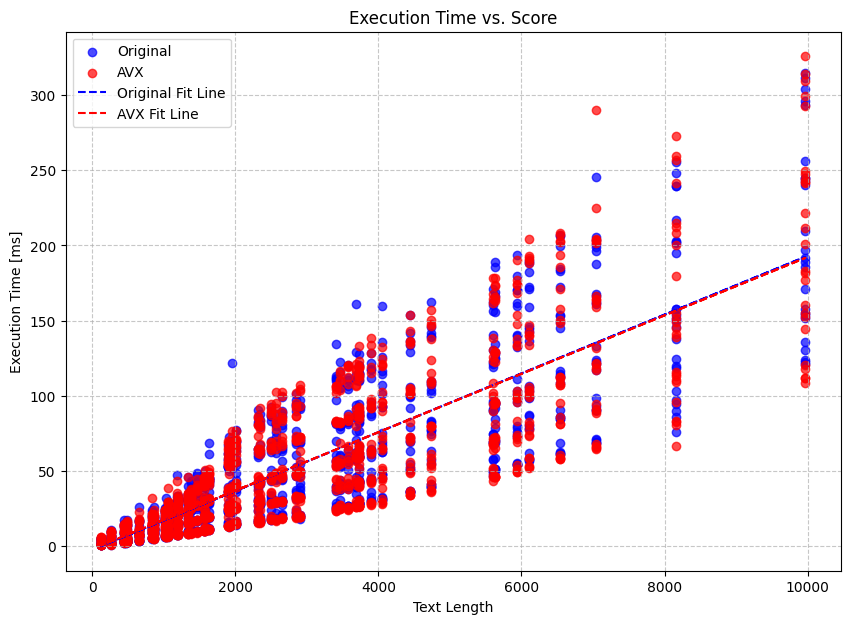

Processing EN with AVX slope: -0.0106, Original slope: -0.0108, Difference: 0.0002


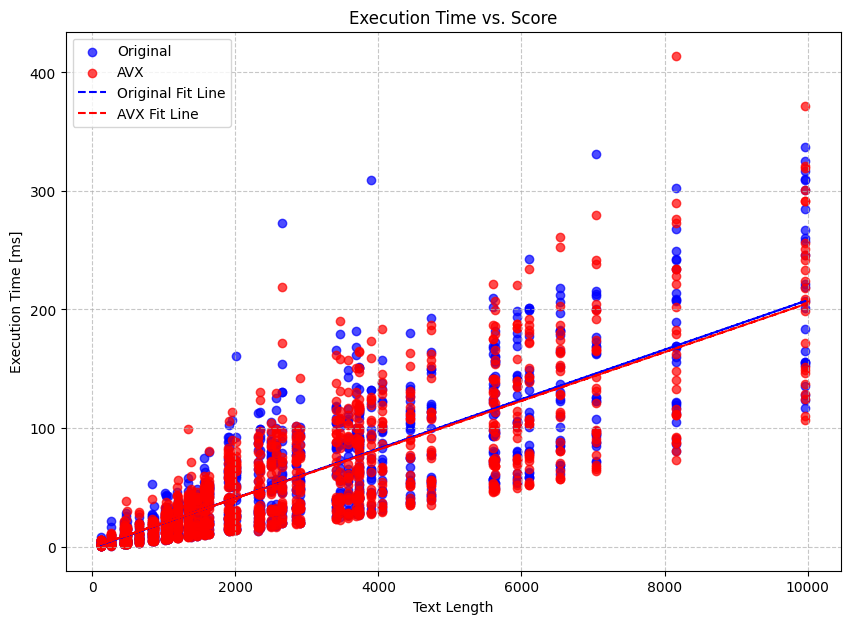

Processing ONB with AVX slope: -0.0100, Original slope: -0.0103, Difference: 0.0003


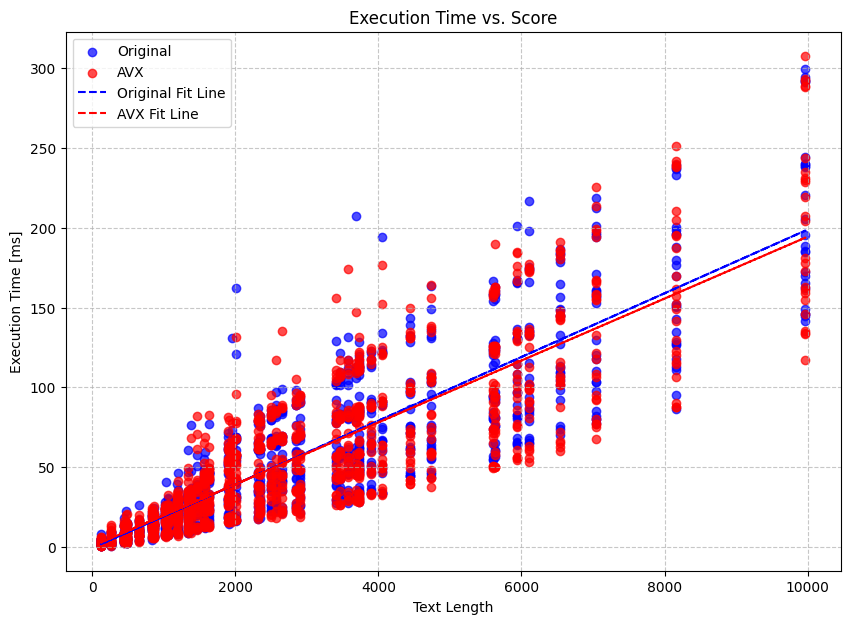

Processing ENB with AVX slope: -0.0096, Original slope: -0.0099, Difference: 0.0003


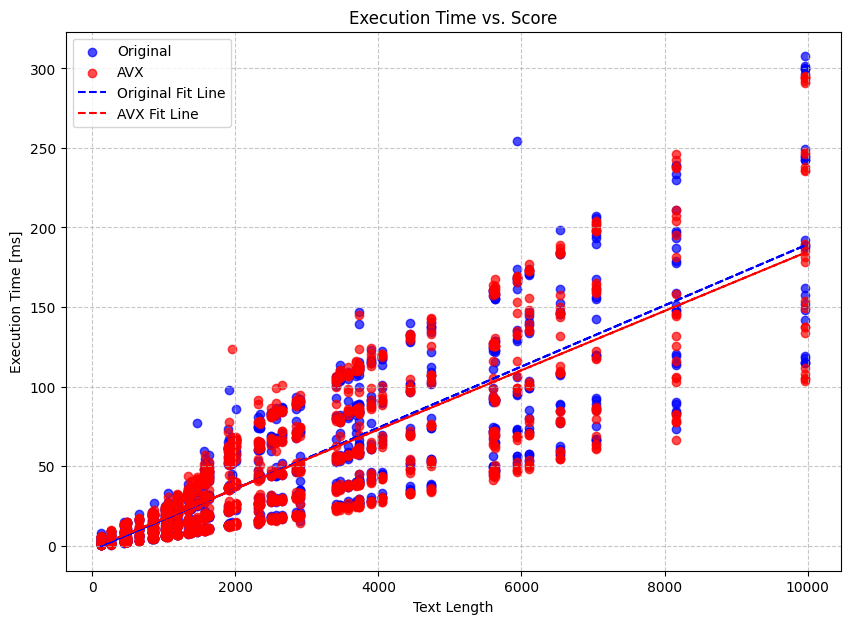

Processing BN with AVX slope: -0.0095, Original slope: -0.0099, Difference: 0.0004


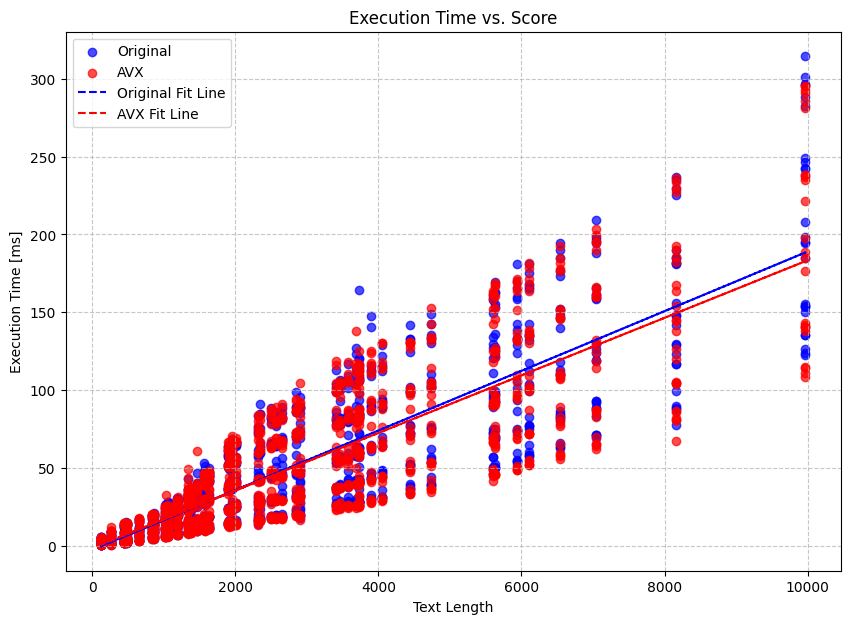

Processing ON with AVX slope: -0.0110, Original slope: -0.0114, Difference: 0.0004


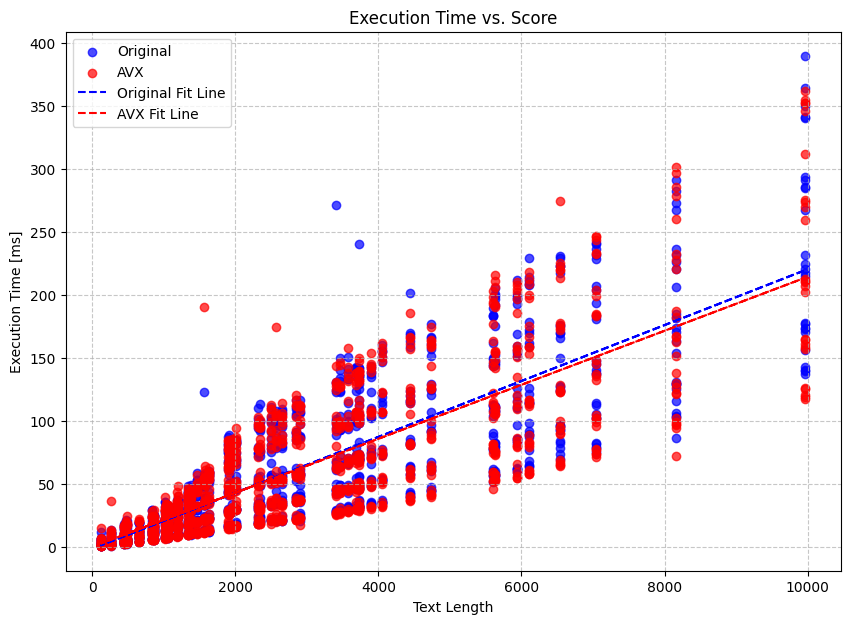

Processing N with AVX slope: -0.0107, Original slope: -0.0112, Difference: 0.0004


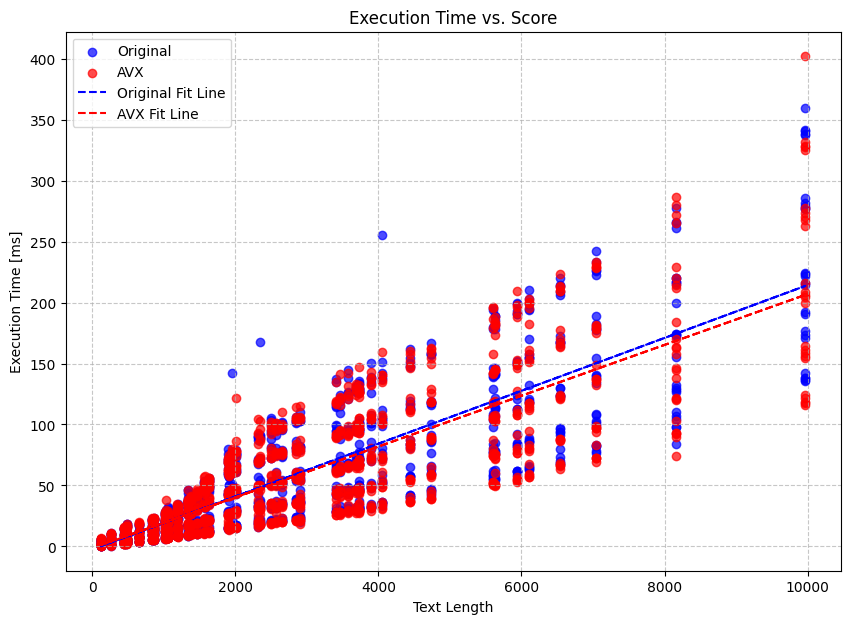

Processing complete with AVX slope: -0.0208, Original slope: -0.0221, Difference: 0.0013


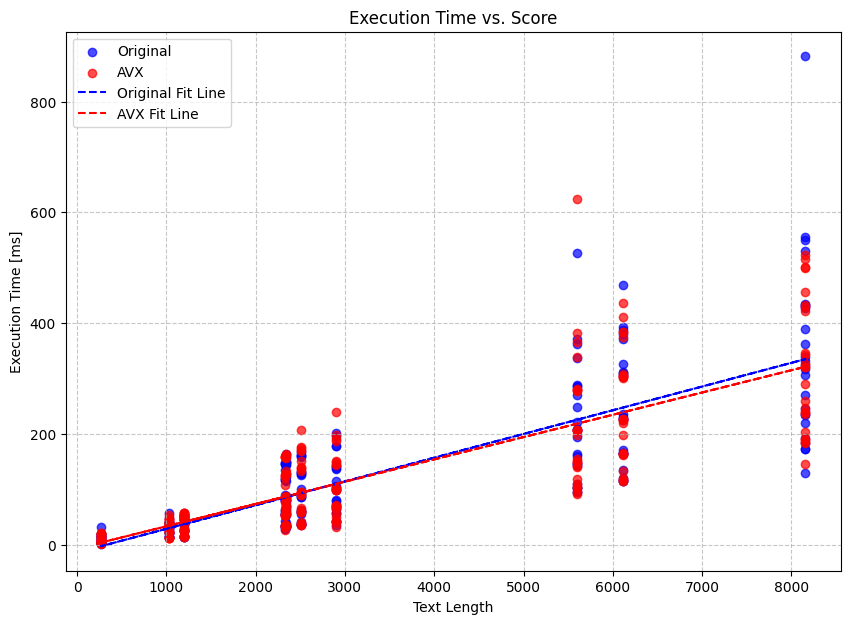

In [6]:
# Calculate the slope for both original times and AVX times, and sort by the difference in slopes (AVX slope - Original slope)
sorted_analyzers = sorted(performance_analyzers.items(), 
                          key=lambda item: np.polyfit(item[1].scores, item[1].avx_times, 1)[0] - np.polyfit(item[1].scores, item[1].original_times, 1)[0], 
                          reverse=False)

# Now process the analyzers in the sorted order
for name, analyzer in sorted_analyzers:
    slope_avx = np.polyfit(analyzer.scores, analyzer.avx_times, 1)[0]
    slope_original = np.polyfit(analyzer.scores, analyzer.original_times, 1)[0]
    slope_diff = slope_avx - slope_original
    print(f"Processing {name} with AVX slope: {slope_avx:.4f}, Original slope: {slope_original:.4f}, Difference: {slope_diff:.4f}")
    analyzer.plot_execution_time_vs_score()

In [7]:
# Dictionary to store results
analyzer_std_devs = []

# Process each analyzer
for name, analyzer in performance_analyzers.items():
    # Collect all unique text lengths for this analyzer
    text_lengths = sorted(set(analyzer.text_lengths))
    
    for length in text_lengths:
        original_times = []
        avx_times = []

        # Gather execution times for the current text length
        for i, text_len in enumerate(analyzer.text_lengths):
            if text_len == length:
                original_times.append(analyzer.original_times[i])
                avx_times.append(analyzer.avx_times[i])

        # Compute standard deviations
        if len(original_times) > 1 and len(avx_times) > 1:
            analyzer_std_devs.append({
                "Analyzer": name,
                "Text Length": length,
                "Original Std Dev": np.std(original_times),
                "AVX Std Dev": np.std(avx_times)
            })

# Convert to DataFrame
std_dev_df = pd.DataFrame(analyzer_std_devs)

# Display results
print(std_dev_df)

# Optional: Sort by text length for readability
std_dev_df = std_dev_df.sort_values(by=["Analyzer", "Text Length"])

     Analyzer  Text Length  Original Std Dev  AVX Std Dev
0    complete          267          7.334512     6.485640
1    complete         1032         11.516927    12.147675
2    complete         1203         13.677086    15.711873
3    complete         2325         40.301161    45.004115
4    complete         2343         43.460230    44.491954
..        ...          ...               ...          ...
642       ONB         6112         43.351167    39.671871
643       ONB         6532         36.149841    41.335964
644       ONB         7042         45.218766    47.298227
645       ONB         8158         45.185746    52.089163
646       ONB         9967         53.001932    57.010748

[647 rows x 4 columns]


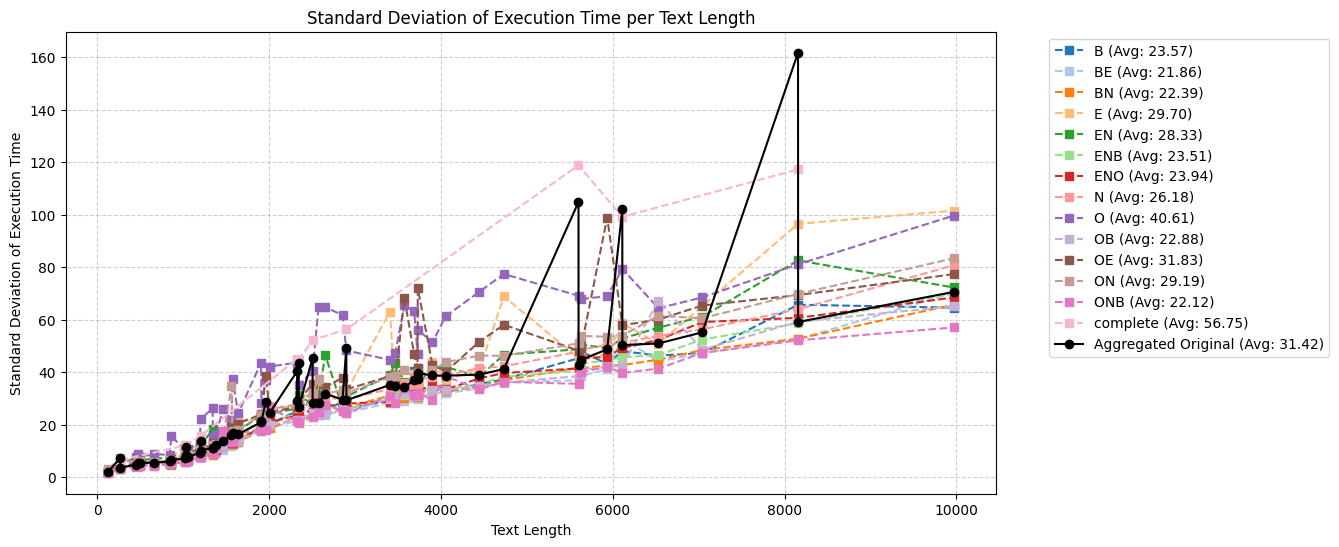

In [8]:
# Compute aggregated mean of Original Std Dev per text length
agg_original_std = std_dev_df.groupby("Text Length")["Original Std Dev"].mean()

# Set up figure
plt.figure(figsize=(12, 6))

# Unique analyzers for colors
unique_analyzers = std_dev_df["Analyzer"].unique()

# Choose a large color palette to accommodate many analyzers
colors = sns.color_palette("tab20", len(unique_analyzers))  # Change "tab10" to "tab20" or another palette

# Plot each analyzer's AVX Standard Deviation
for idx, analyzer in enumerate(unique_analyzers):
    subset = std_dev_df[std_dev_df["Analyzer"] == analyzer]
    avg_avx_std = subset["AVX Std Dev"].mean()  # Compute average standard deviation for AVX
    plt.plot(subset["Text Length"], subset["AVX Std Dev"], 
             marker="s", linestyle="--", label=f"{analyzer} (Avg: {avg_avx_std:.2f})", color=colors[idx])

# Plot Aggregated Original Standard Deviation
avg_original_std = agg_original_std.mean()  # Compute average of aggregated original std deviation
plt.plot(agg_original_std.index, agg_original_std.values, 
         marker="o", linestyle="-", color="black", label=f"Aggregated Original (Avg: {avg_original_std:.2f})")

# Labels and Legends
plt.xlabel("Text Length")
plt.ylabel("Standard Deviation of Execution Time")
plt.title("Standard Deviation of Execution Time per Text Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()

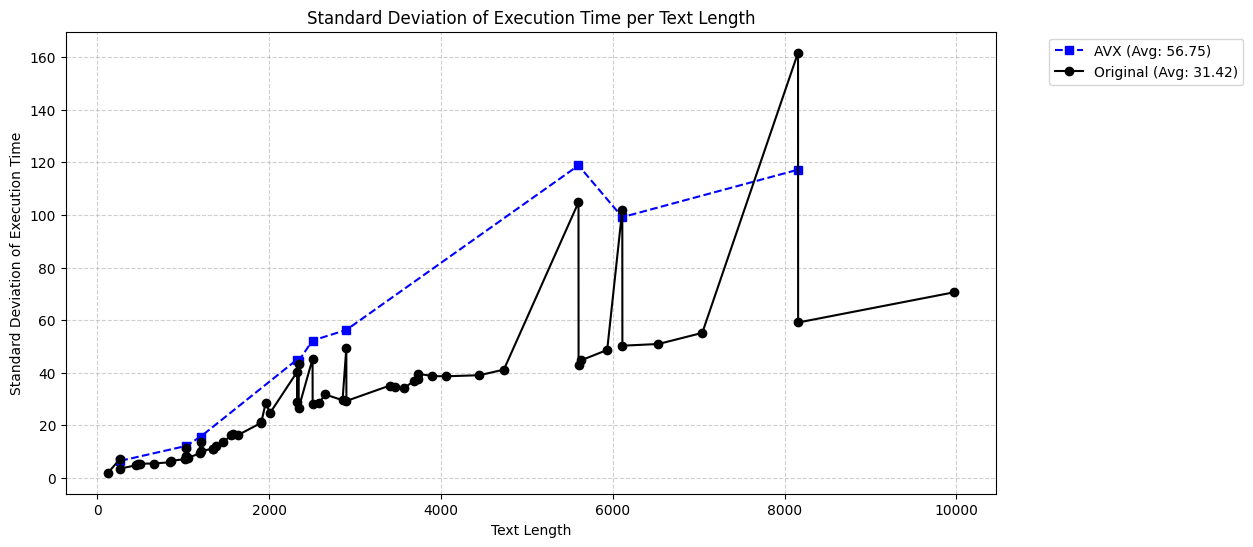

In [9]:
# Compute aggregated mean of Original Std Dev per text length
agg_original_std = std_dev_df.groupby("Text Length")["Original Std Dev"].mean()

# Set up figure
plt.figure(figsize=(12, 6))

# Filter for the "complete" analyzer
complete_subset = std_dev_df[std_dev_df["Analyzer"] == "complete"]

# Plot "complete" analyzer's AVX Standard Deviation
avg_avx_std = complete_subset["AVX Std Dev"].mean()  # Compute average standard deviation for AVX
plt.plot(complete_subset["Text Length"], complete_subset["AVX Std Dev"], 
         marker="s", linestyle="--", label=f"AVX (Avg: {avg_avx_std:.2f})", color="blue")

# Plot Aggregated Original Standard Deviation
avg_original_std = agg_original_std.mean()  # Compute average of aggregated original std deviation
plt.plot(agg_original_std.index, agg_original_std.values, 
         marker="o", linestyle="-", color="black", label=f"Original (Avg: {avg_original_std:.2f})")

# Labels and Legends
plt.xlabel("Text Length")
plt.ylabel("Standard Deviation of Execution Time")
plt.title("Standard Deviation of Execution Time per Text Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()

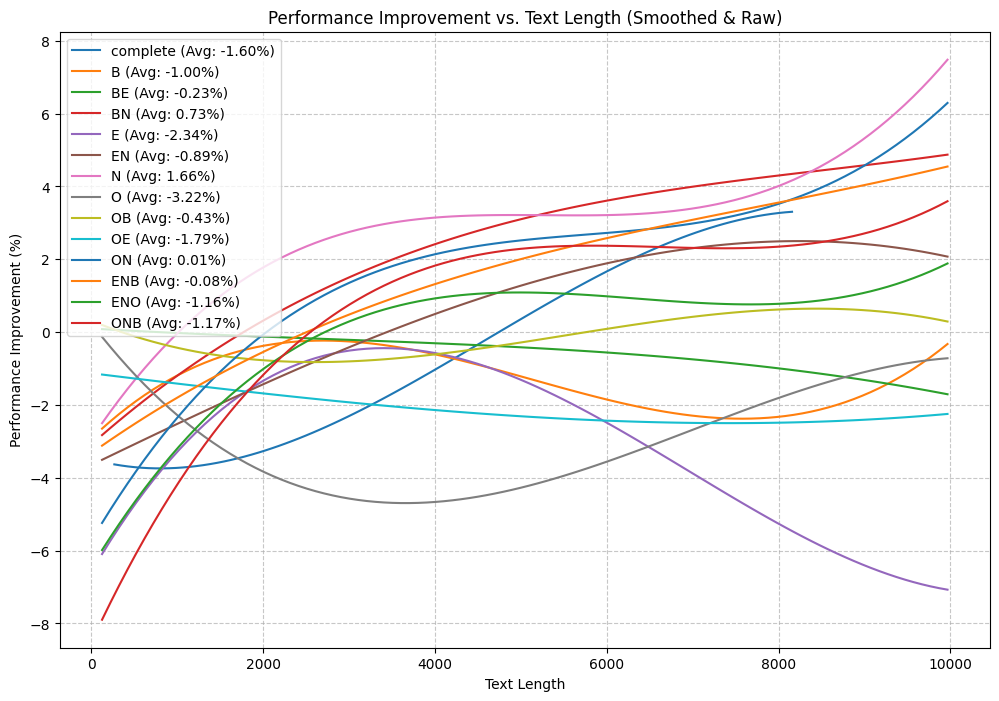

In [10]:
# Create a figure
plt.figure(figsize=(12, 8))

# Find the analyzer with the highest average improvement
max_avg_improvement = float('-inf')
best_analyzer = None

for name, analyzer in performance_analyzers.items():
    avg_improvement = np.mean(analyzer.improvements)
    if avg_improvement > max_avg_improvement:
        max_avg_improvement = avg_improvement
        best_analyzer = name

# Iterate over all performance analyzers
for name, analyzer in performance_analyzers.items():
    # Ensure data is sorted by text length
    sorted_indices = np.argsort(analyzer.text_lengths)
    sorted_text_lengths = np.array(analyzer.text_lengths)[sorted_indices]
    sorted_improvements = np.array(analyzer.improvements)[sorted_indices]

    # Fit a cubic polynomial (degree 3) for smooth trend
    poly_coeffs = np.polyfit(sorted_text_lengths, sorted_improvements, deg=3)
    poly_fit = np.poly1d(poly_coeffs)

    # Generate smooth x values for plotting the curve
    smooth_x = np.linspace(min(sorted_text_lengths), max(sorted_text_lengths), 100)
    smooth_y = poly_fit(smooth_x)

    # Determine opacity
    alpha_value = 1.0 if name == best_analyzer else 1.0

    # Plot the smoothed trend line
    plt.plot(smooth_x, smooth_y, linestyle='-', label=f"{name} (Avg: {np.mean(analyzer.improvements):.2f}%)", alpha=alpha_value)

# Set labels and title
plt.xlabel("Text Length")
plt.ylabel("Performance Improvement (%)")
plt.title("Performance Improvement vs. Text Length (Smoothed & Raw)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.show()


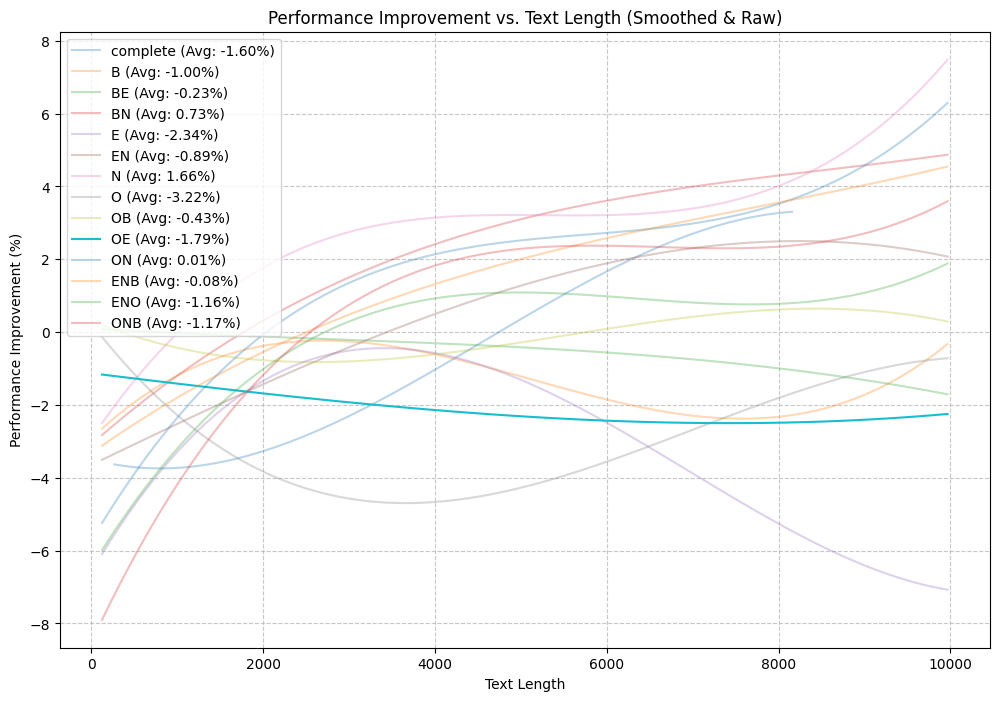

In [11]:
# Create a figure
plt.figure(figsize=(12, 8))

# Compute average improvements for all analyzers
avg_improvements = {name: np.mean(analyzer.improvements) for name, analyzer in performance_analyzers.items()}

# Sort analyzers by average improvement
sorted_analyzers = sorted(avg_improvements, key=avg_improvements.get)

# Identify the third-lowest analyzer (fallback to the lowest available if fewer exist)
third_lowest_analyzer = sorted_analyzers[2] if len(sorted_analyzers) > 2 else sorted_analyzers[-1]

# Iterate over all performance analyzers
for name, analyzer in performance_analyzers.items():
    # Ensure data is sorted by text length
    sorted_indices = np.argsort(analyzer.text_lengths)
    sorted_text_lengths = np.array(analyzer.text_lengths)[sorted_indices]
    sorted_improvements = np.array(analyzer.improvements)[sorted_indices]

    # Fit a cubic polynomial (degree 3) for smooth trend
    poly_coeffs = np.polyfit(sorted_text_lengths, sorted_improvements, deg=3)
    poly_fit = np.poly1d(poly_coeffs)

    # Generate smooth x values for plotting the curve
    smooth_x = np.linspace(min(sorted_text_lengths), max(sorted_text_lengths), 100)
    smooth_y = poly_fit(smooth_x)

    # Determine opacity
    alpha_value = 1.0 if name == third_lowest_analyzer else 0.3  # Third lowest gets full opacity

    # Plot the smoothed trend line
    plt.plot(smooth_x, smooth_y, linestyle='-', label=f"{name} (Avg: {avg_improvements[name]:.2f}%)", alpha=alpha_value)

# Set labels and title
plt.xlabel("Text Length")
plt.ylabel("Performance Improvement (%)")
plt.title("Performance Improvement vs. Text Length (Smoothed & Raw)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [12]:
# Dictionary to store average improvement for each analyzer
improvement_stats = {name: np.mean(analyzer.improvements) for name, analyzer in performance_analyzers.items()}

# Convert to DataFrame for easy sorting
df = pd.DataFrame(list(improvement_stats.items()), columns=["Name", "Avg Improvement (%)"])

# Sort by improvement percentage
df_sorted = df.sort_values(by="Avg Improvement (%)", ascending=False)

# Get top 3 best and worst performers
top_3 = df_sorted.head(3).reset_index(drop=True)
bottom_3 = df_sorted.tail(3).reset_index(drop=True)

# Create a new DataFrame with separate columns for best and worst
comparison_table = pd.DataFrame({
    "Best (Highest Improvement)": top_3["Name"],
    "Best Avg Improvement (%)": top_3["Avg Improvement (%)"],
    "Worst (Lowest Improvement)": bottom_3["Name"],
    "Worst Avg Improvement (%)": bottom_3["Avg Improvement (%)"]
})

# Display the table
print(comparison_table.to_string(index=False))

Best (Highest Improvement)  Best Avg Improvement (%) Worst (Lowest Improvement)  Worst Avg Improvement (%)
                         N                  1.658881                         OE                  -1.792847
                        BN                  0.730537                          E                  -2.341666
                        ON                  0.011468                          O                  -3.216377


In [13]:
# Define text length ranges
ranges = {
    "0-500": lambda x: x < 500,
    "500-1000": lambda x: 500 <= x < 1000,
    "1000-2000": lambda x: 1000 <= x < 2000,
    "2000-5000": lambda x: 2000 <= x < 5000,
    "5000-10,000": lambda x: x > 5000
}

# Dictionary to store results for each range
range_results = {}

for range_name, condition in ranges.items():
    improvement_stats = {}

    # Compute the average improvement for each performance analyzer within the range
    for name, analyzer in performance_analyzers.items():
        filtered_improvements = [imp for imp, length in zip(analyzer.improvements, analyzer.text_lengths) if condition(length)]
        
        if filtered_improvements:
            avg_improvement = np.mean(filtered_improvements)
            improvement_stats[name] = avg_improvement

    # Convert to DataFrame and sort
    df = pd.DataFrame(list(improvement_stats.items()), columns=["Name", "Avg Improvement (%)"])
    df_sorted = df.sort_values(by="Avg Improvement (%)", ascending=False)

    # Get top 3 best and worst performers
    top_3 = df_sorted.head(3).reset_index(drop=True)
    bottom_3 = df_sorted.tail(3).reset_index(drop=True)

    # Store in results dictionary
    range_results[range_name] = pd.DataFrame({
        "Best (Highest Improvement)": top_3["Name"],
        "Best Avg Improvement (%)": top_3["Avg Improvement (%)"],
        "Worst (Lowest Improvement)": bottom_3["Name"],
        "Worst Avg Improvement (%)": bottom_3["Avg Improvement (%)"]
    })

# Function to color-code values using blue-to-red scale (blue = best)
def highlight_values(val):
    global min_value, max_value

    # Ensure min < center < max
    midpoint = (min_value + max_value) / 2
    vcenter = max(min(midpoint, max_value - 1), min_value + 1)  # Keep it inside bounds

    norm = mcolors.TwoSlopeNorm(vmin=min_value, vcenter=vcenter, vmax=max_value)
    cmap = plt.get_cmap("coolwarm_r")  # "_r" reverses colormap: Blue = High, Red = Low
    rgba = cmap(norm(val))
    
    # Convert RGBA to RGB (0-255 range)
    r, g, b = int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)
    brightness = (r * 0.299 + g * 0.587 + b * 0.114)  # Perceived brightness

    # Set text color: black for light backgrounds, white otherwise
    text_color = "black" if brightness > 160 else "white"

    return f"background-color: rgb({r},{g},{b}); color: {text_color};"

# Display color-coded tables
for range_name, table in range_results.items():
    print(f"\n=== {range_name} ===")

    # Get min and max improvement for color scaling
    min_value = table[["Best Avg Improvement (%)", "Worst Avg Improvement (%)"]].min().min()
    max_value = table[["Best Avg Improvement (%)", "Worst Avg Improvement (%)"]].max().max()

    # Apply color formatting using `.map()`
    styled_table = table.style.map(highlight_values, subset=["Best Avg Improvement (%)", "Worst Avg Improvement (%)"])

    # Display the styled table (for Jupyter Notebook)
    display(styled_table)


=== 0-500 ===


,Best (Highest Improvement),Best Avg Improvement (%),Worst (Lowest Improvement),Worst Avg Improvement (%)
0,OB,0.454785,ON,-4.669200
1,BE,0.211150,ENO,-5.175344
2,EN,-1.312969,ONB,-9.757277



=== 500-1000 ===


,Best (Highest Improvement),Best Avg Improvement (%),Worst (Lowest Improvement),Worst Avg Improvement (%)
0,OE,1.901947,ENO,-4.725501
1,N,0.824534,O,-5.185965
2,BE,0.457626,E,-5.337647



=== 1000-2000 ===


,Best (Highest Improvement),Best Avg Improvement (%),Worst (Lowest Improvement),Worst Avg Improvement (%)
0,N,1.299243,OE,-2.111280
1,B,-0.132337,EN,-3.215995
2,BE,-0.314544,complete,-5.943498



=== 2000-5000 ===


,Best (Highest Improvement),Best Avg Improvement (%),Worst (Lowest Improvement),Worst Avg Improvement (%)
0,N,2.360391,OE,-1.917718
1,BN,1.831585,complete,-1.984068
2,ON,1.270691,O,-5.660246



=== 5000-10,000 ===


,Best (Highest Improvement),Best Avg Improvement (%),Worst (Lowest Improvement),Worst Avg Improvement (%)
0,N,4.016768,O,-2.029360
1,BN,3.883451,OE,-2.236916
2,ONB,3.318706,E,-3.274798
